In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (10, 7)
import seaborn as sns
sns.set()

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import load_boston

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# 보스턴 집값 데이터 불러오기
boston = load_boston()

In [3]:
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [4]:
# 보스턴 집값 데이터 정보
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [5]:
# 데이터 프레임 만들기
# 특성 데이터
boston_df = pd.DataFrame(boston['data'], columns=boston['feature_names'])
# 타겟 데이터
boston_df['MEDV'] = boston['target']
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [6]:
# 입출력 데이터 구성
x_data = boston_df.drop('MEDV', axis=1)
y_data = boston_df['MEDV']

x_data.shape, y_data.shape

((506, 13), (506,))

In [7]:
# 훈련용, 테스트용 데이터 구성
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=0)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((404, 13), (102, 13), (404,), (102,))

### pipeline으로 모델 생성

In [8]:
# 학습
# make_pipeline을 이용해 스케일링과 회귀 학습을 한번에 처리한다
model = make_pipeline(StandardScaler(), SGDRegressor())
model.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor', SGDRegressor())])

In [9]:
model.score(x_train, y_train)

0.7699303348122819

In [10]:
model.score(x_test, y_test)

0.5830789706486763

### 교차 검증
- 계산양을 좀 더 사용해서 모델의 안정성을 추구할 수 있다
- 데이터를 동일한 조각으로 분할한 후 데이터의 한 조각만을 제외하고 나머지 모든 부분에 관해 훈련하고 훈련에서 제외한 부분을 이용해 검증을 수행한다 이 과정을 설정한 횟수만큼 반복한다

In [11]:
kfold = KFold(n_splits=10, shuffle=True, random_state=0)

In [12]:
# 교차검증 r2 score 값들
r2_scores = cross_val_score(model, x_data, y_data, cv=kfold, scoring='r2', verbose=1)
r2_scores

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


array([0.48154292, 0.64016504, 0.79241617, 0.77943643, 0.52485398,
       0.76873205, 0.7668022 , 0.58430173, 0.85496498, 0.7989948 ])

In [13]:
# 교차검증한 r2 score의 평균
r2_scores.mean()

0.6992210314426528

r2 score 평균값이 매우 작으므로 신뢰하기 어렵다 -> 다중공선성을 확인한다

### 다중공선성(Multicollinearity)
- 회귀 분석에서 사용된 모형의 일부 설명 변수가 다른 설명 변수와 상관 정도가 높아 데이터 분석시 부정적인 영향을 미치는 현상

ex) 음주량, 혈중 알코올 농도 두 변수로 혈압을 측정할 때 특성 데이터 간의 상관관계가 높아(음주를 많이 하면 당연히 혈중 알코올 농도가 높다) 설명력이 떨어진다 

In [14]:
# 다중공선성 데이터 프레임 생성
vif = pd.DataFrame()
# 다중공선성 계산값 컬럼 추가
vif['VIF Factor'] = [variance_inflation_factor(boston_df.values, i) for i in range(boston_df.shape[1])]
# 컬렴명 추가
vif['feature'] = boston_df.columns
# VIF Factor 값이 큰 순으로 정렬
vif.sort_values(by='VIF Factor', ascending=False, inplace=True)
vif

,VIF Factor,feature
5,136.101743,RM
10,87.227233,PTRATIO
4,74.004269,NOX
9,61.939713,TAX
13,24.503206,MEDV
6,21.398863,AGE
11,21.351015,B
7,15.430455,DIS
8,15.369980,RAD
2,14.485874,INDUS


### 상관관계

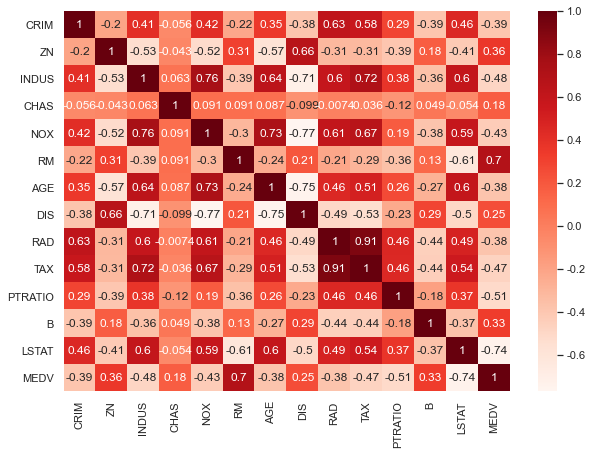

In [15]:
sns.heatmap(boston_df.corr(), annot=True, cmap='Reds')
plt.show()

1. 다중공선성 확인 -> 높은 값을 가지는 컬럼을 제거후 다시 다중공선성을 확인한다.(만족하는 값을 가질 때까지 반복)
2. 타겟 데이터와 특성 데이터의 상관관계 확인 -> 값이 낮은 컬럼 제거

### 다중공선성이 높은 컬럼 제거 후 학습 
- 다중공선성 값 15이하를 목표로 한다

In [16]:
vif.head()

,VIF Factor,feature
5,136.101743,RM
10,87.227233,PTRATIO
4,74.004269,NOX
9,61.939713,TAX
13,24.503206,MEDV


In [17]:
x_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [18]:
# RM 컬럼 제거 후 다중공선성 확인
x_data.drop('RM', axis=1, inplace=True)

# 다중공선성 데이터 프레임 생성
vif = pd.DataFrame()
# 다중공선성 계산값 컬럼 추가
vif['VIF Factor'] = [variance_inflation_factor(x_data.values, i) for i in range(x_data.shape[1])]
# 컬렴명 추가
vif['feature'] = x_data.columns
# VIF Factor 값이 큰 순으로 정렬
vif.sort_values(by='VIF Factor', ascending=False, inplace=True)
vif.head()

,VIF Factor,feature
9,66.103989,PTRATIO
8,61.225901,TAX
4,55.588774,NOX
5,20.450687,AGE
10,19.643808,B


In [19]:
# PTRATIO 컬럼 제거 후 다중공선성 확인
x_data.drop('PTRATIO', axis=1, inplace=True)

# 다중공선성 데이터 프레임 생성
vif = pd.DataFrame()
# 다중공선성 계산값 컬럼 추가
vif['VIF Factor'] = [variance_inflation_factor(x_data.values, i) for i in range(x_data.shape[1])]
# 컬렴명 추가
vif['feature'] = x_data.columns
# VIF Factor 값이 큰 순으로 정렬
vif.sort_values(by='VIF Factor', ascending=False, inplace=True)
vif.head()

,VIF Factor,feature
8,58.686042,TAX
4,50.491344,NOX
5,19.961762,AGE
9,16.588839,B
7,15.102917,RAD


In [20]:
# TAX 컬럼 제거 후 다중공선성 확인
x_data.drop('TAX', axis=1, inplace=True)

# 다중공선성 데이터 프레임 생성
vif = pd.DataFrame()
# 다중공선성 계산값 컬럼 추가
vif['VIF Factor'] = [variance_inflation_factor(x_data.values, i) for i in range(x_data.shape[1])]
# 컬렴명 추가
vif['feature'] = x_data.columns
# VIF Factor 값이 큰 순으로 정렬
vif.sort_values(by='VIF Factor', ascending=False, inplace=True)
vif.head()

,VIF Factor,feature
4,46.856834,NOX
5,19.899777,AGE
8,16.435073,B
2,11.010840,INDUS
6,9.086148,DIS


In [21]:
# NOX 컬럼 제거 후 다중공선성 확인
x_data.drop('NOX', axis=1, inplace=True)

# 다중공선성 데이터 프레임 생성
vif = pd.DataFrame()
# 다중공선성 계산값 컬럼 추가
vif['VIF Factor'] = [variance_inflation_factor(x_data.values, i) for i in range(x_data.shape[1])]
# 컬렴명 추가
vif['feature'] = x_data.columns
# VIF Factor 값이 큰 순으로 정렬
vif.sort_values(by='VIF Factor', ascending=False, inplace=True)
vif.head()

,VIF Factor,feature
4,14.000758,AGE
7,13.537020,B
2,9.016142,INDUS
5,8.447694,DIS
8,8.358925,LSTAT


다중공선성 값이 15이하가 됐으므로 더이상 컬럼을 제거하지 않는다

In [22]:
# 교차 검증
r2 = cross_val_score(model, x_data, y_data, scoring='r2', cv=kfold, verbose=1)
r2

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


array([0.54923278, 0.37441772, 0.71187182, 0.6467875 , 0.46460238,
       0.63213675, 0.60178686, 0.61113328, 0.71544383, 0.71348971])

In [23]:
r2.mean()

0.602090264545031

다중공선성 높은 컬럼을 제거한 후 오히려 더 낮은 r2 score값이 나왔다 -> 타겟과 상관관계가 높은 컬럼을 제거하였기 때문이라 추측

### 상관관계 낮고 다중공선성 높은 컬럼 제거 후 학습

In [24]:
x_data = boston_df.drop('MEDV', axis=1)
x_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [25]:
# 상관관계
boston_df.corr().loc['MEDV'].sort_values(ascending=False)

MEDV       1.000000
RM         0.695360
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
AGE       -0.376955
RAD       -0.381626
CRIM      -0.388305
NOX       -0.427321
TAX       -0.468536
INDUS     -0.483725
PTRATIO   -0.507787
LSTAT     -0.737663
Name: MEDV, dtype: float64

In [26]:
# 다중공선성 데이터 프레임 생성
vif = pd.DataFrame()
# 다중공선성 계산값 컬럼 추가
vif['VIF Factor'] = [variance_inflation_factor(x_data.values, i) for i in range(x_data.shape[1])]
# 컬렴명 추가
vif['feature'] = x_data.columns
# VIF Factor 값이 큰 순으로 정렬
vif.sort_values(by='VIF Factor', ascending=False, inplace=True)
vif.head()

,VIF Factor,feature
10,85.029547,PTRATIO
5,77.948283,RM
4,73.894947,NOX
9,61.227274,TAX
6,21.386850,AGE


In [27]:
# PTRATIO 컬럼 제거 -> 상관관계 낮고 다중공선성 높다
x_data.drop('PTRATIO', axis=1, inplace=True)

# 다중공선성 데이터 프레임 생성
vif = pd.DataFrame()
# 다중공선성 계산값 컬럼 추가
vif['VIF Factor'] = [variance_inflation_factor(x_data.values, i) for i in range(x_data.shape[1])]
# 컬렴명 추가
vif['feature'] = x_data.columns
# VIF Factor 값이 큰 순으로 정렬
vif.sort_values(by='VIF Factor', ascending=False, inplace=True)
vif.head()

,VIF Factor,feature
4,73.894171,NOX
5,60.598846,RM
9,59.301541,TAX
6,21.361234,AGE
10,18.614751,B


In [28]:
# NOX 컬럼 제거 -> 상관관계 낮고 다중공선성 높다
x_data.drop('NOX', axis=1, inplace=True)

# 다중공선성 데이터 프레임 생성
vif = pd.DataFrame()
# 다중공선성 계산값 컬럼 추가
vif['VIF Factor'] = [variance_inflation_factor(x_data.values, i) for i in range(x_data.shape[1])]
# 컬렴명 추가
vif['feature'] = x_data.columns
# VIF Factor 값이 큰 순으로 정렬
vif.sort_values(by='VIF Factor', ascending=False, inplace=True)
vif.head()

,VIF Factor,feature
8,57.720347,TAX
4,41.406746,RM
5,19.889623,AGE
9,18.396072,B
7,15.155012,RAD


In [29]:
# TAX 컬럼 제거 -> 상관관계 낮고 다중공선성 높다
x_data.drop('TAX', axis=1, inplace=True)

# 다중공선성 데이터 프레임 생성
vif = pd.DataFrame()
# 다중공선성 계산값 컬럼 추가
vif['VIF Factor'] = [variance_inflation_factor(x_data.values, i) for i in range(x_data.shape[1])]
# 컬렴명 추가
vif['feature'] = x_data.columns
# VIF Factor 값이 큰 순으로 정렬
vif.sort_values(by='VIF Factor', ascending=False, inplace=True)
vif.head()

,VIF Factor,feature
4,39.069063,RM
5,19.780944,AGE
8,18.289917,B
6,11.817803,DIS
2,9.290080,INDUS


RM은 상관관계가 높으므로 제거하지 않고 컬럼 제거를 종료하고 교차 검증한다

In [30]:
# 교차 검증
r2 = cross_val_score(model, x_data, y_data, scoring='r2', cv=kfold, verbose=1)
r2

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


array([0.49432452, 0.61199813, 0.74487281, 0.7719379 , 0.37456542,
       0.72799184, 0.68266484, 0.55876178, 0.8199964 , 0.80445377])

In [31]:
r2.mean()

0.6591567415577335

상관관계가 높은 컬럼을 제거하기 전보다 r2 score값이 높아졌으나 컬럼을 제거하지 않고 전체를 학습할 때보다 값이 낮다 

-> 다중공선성 높은 컬럼을 제거 한다고 무조건 r2 score값이 높아지지 않는다 확인해보고 더 좋은 결과의 데이터를 사용한다